In [1]:
from PIL import Image
import numpy as np

In [2]:
import gzip
import pickle
with gzip.open("../Week02/mnist.pkl.gz", 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

In [3]:
train_X, train_y = train_set
validation_X, validation_y = validation_set
test_X, test_y = test_set

In [4]:
from IPython.display import display
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*784 -> N*28*28 -> 28*N*28 -> 28 * 28N
    int_X_reshape = int_X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y)

[5 0 4 ..., 8 4 8]


## 開始 Tensorflow

In [5]:
import tensorflow as tf
from tfdot import tfdot

# Multilayer Convolutional Network

In [22]:
# 重設 session 和 graph
tf.reset_default_graph()
sess = tf.InteractiveSession()
# 輸入還是一樣
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Y_")

In [23]:
# 設定 weight 和 bais
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name ='W')
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = 'b')

In [24]:
# 設定 cnn 的 layers
def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

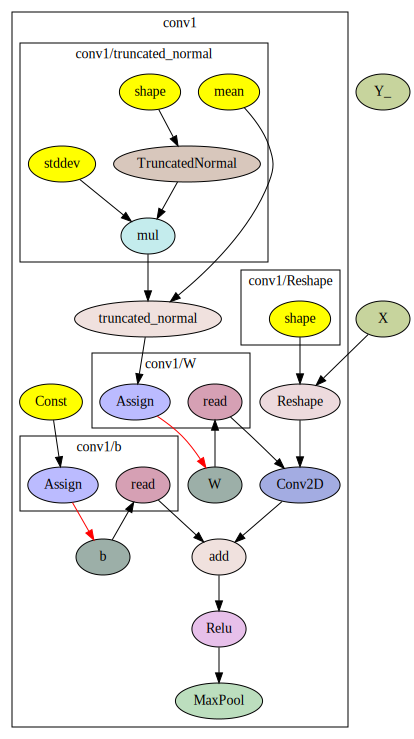

In [25]:
# fisrt layer
with tf.name_scope('conv1'):
    ## variables
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])
    ## build the layer
    X_image = tf.reshape(X, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(X_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)


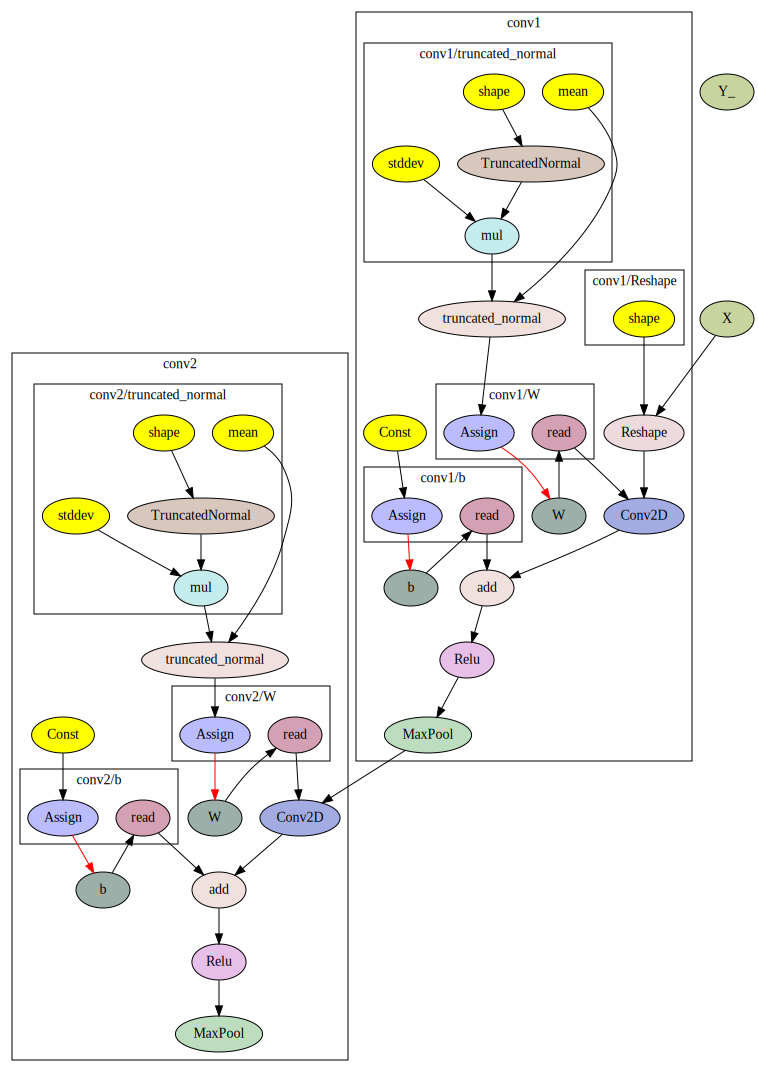

In [26]:
# second layer
with tf.name_scope('conv2'):
    ## variables
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])
    ## build the layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)


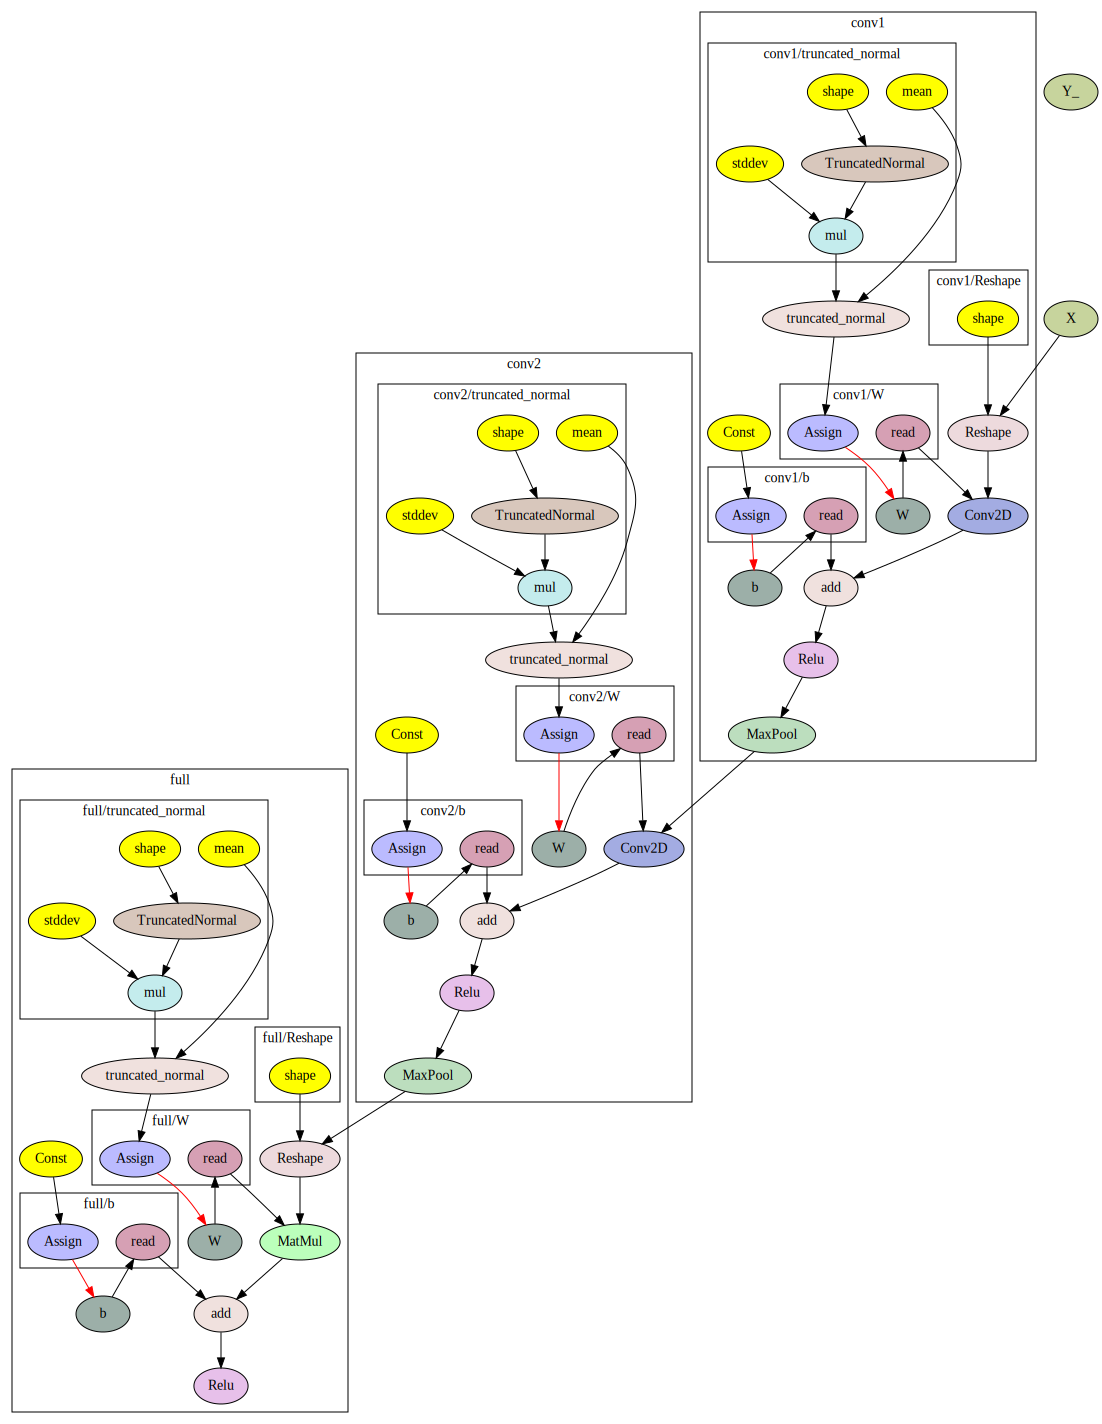

In [27]:
# fully-connected layer
with tf.name_scope('full'):
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1)+b_fc1)


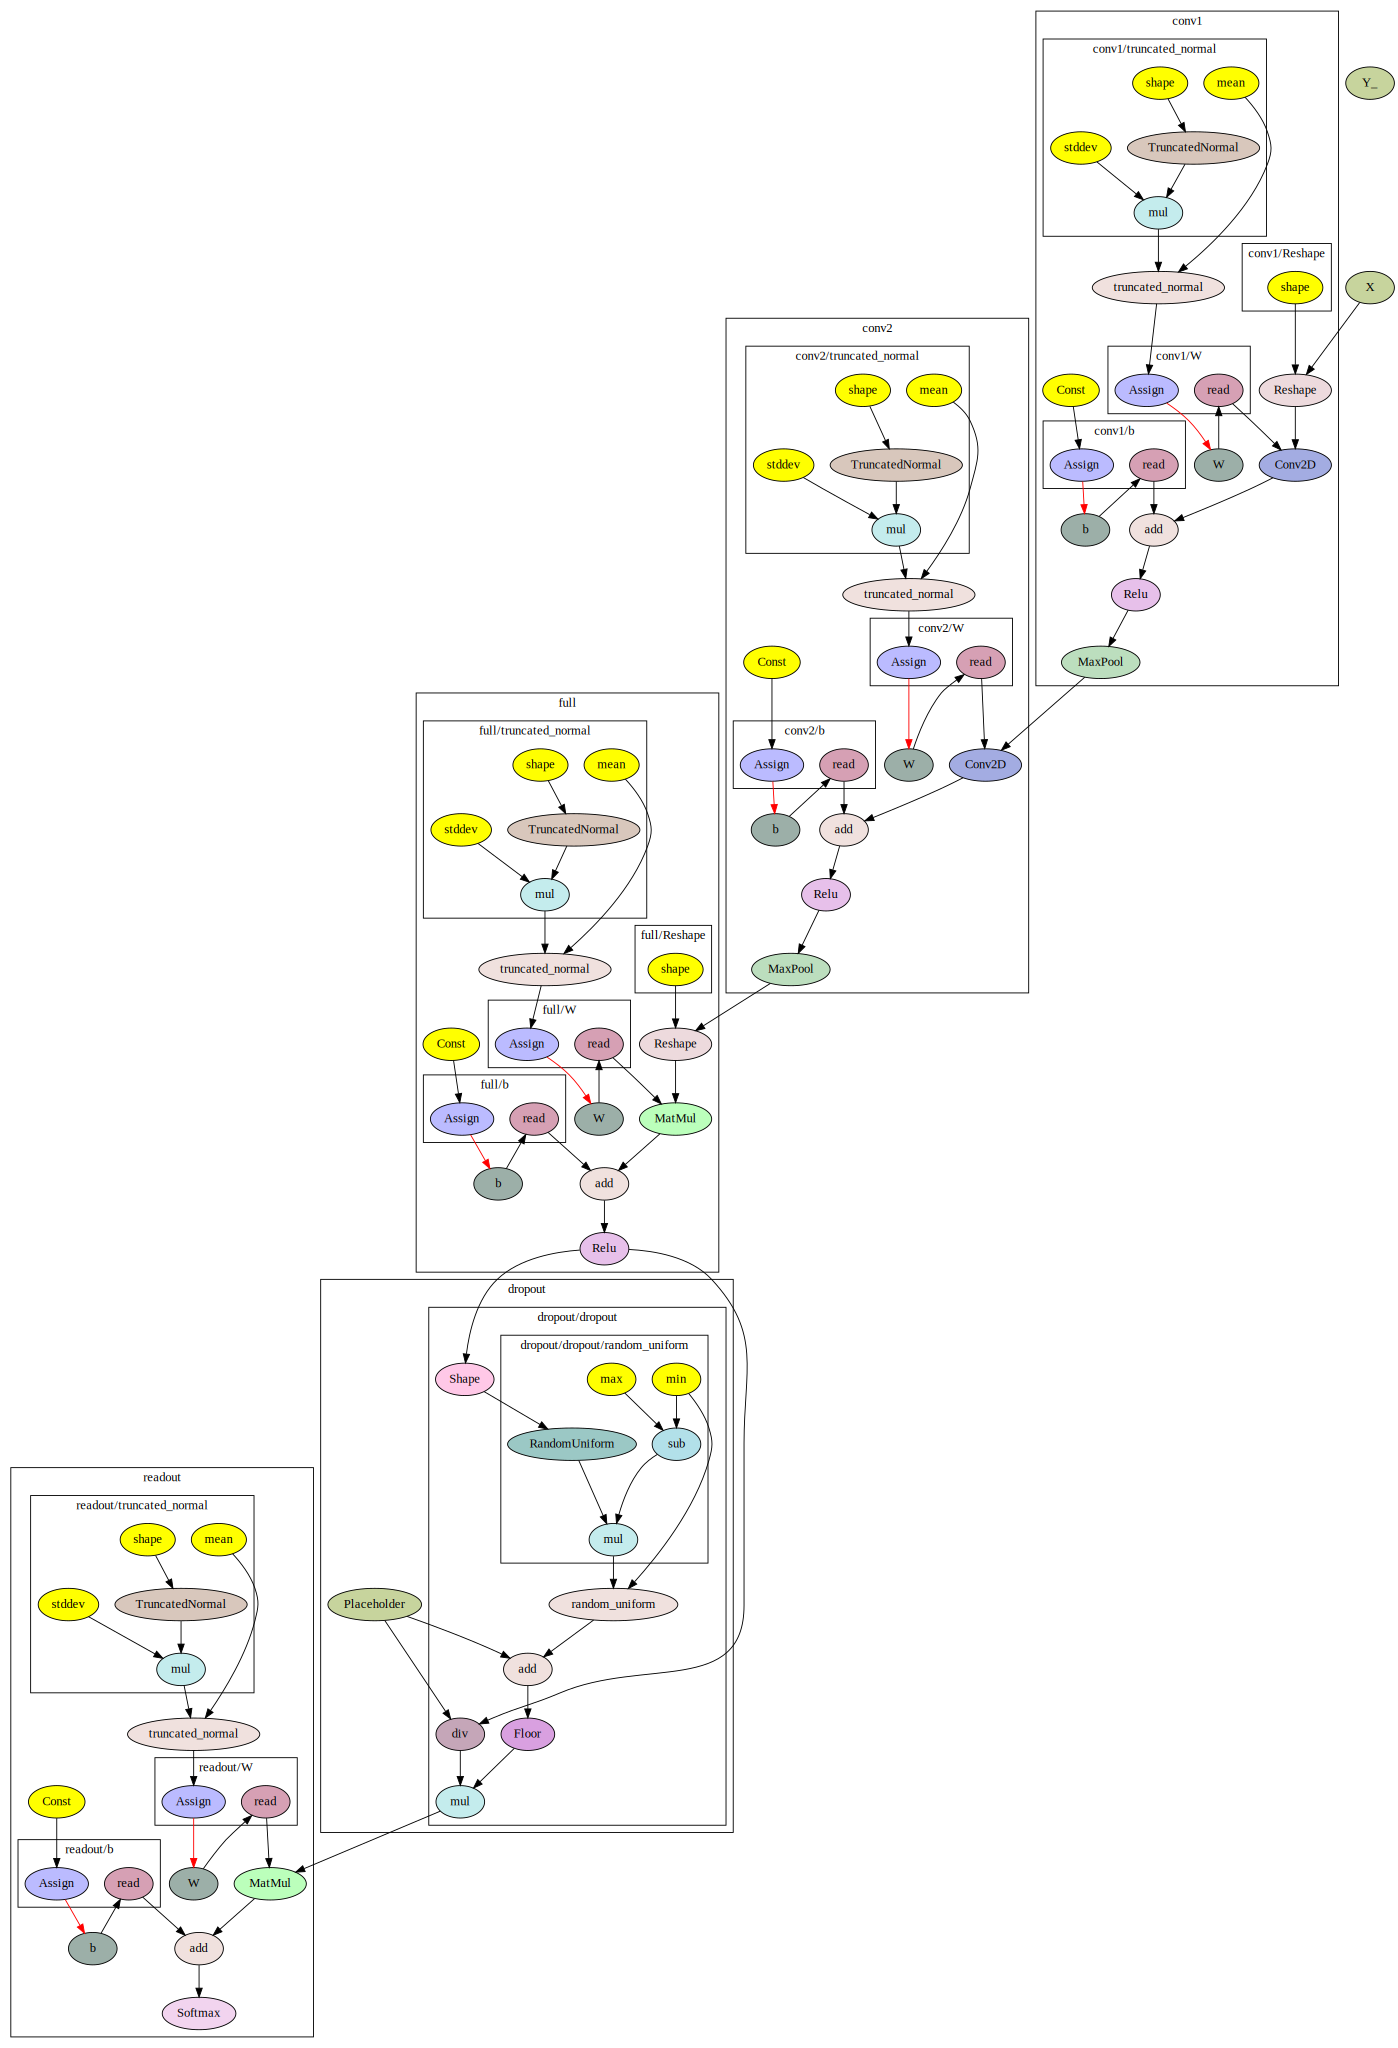

In [28]:
# Dropout:  A Simple Way to Prevent Neural Networks from Over fitting
# https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder("float")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout
with tf.name_scope('readout'):
    W_fc2 = weight_variable([1024,10])
    b_fc2 = bias_variable([10])
    Y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2)+b_fc2)


In [29]:
cross_entropy =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(Y, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [45]:
tf.scalar_summary(accuracy.op.name, accuracy)
summary_op = tf.merge_all_summaries()
summary_writer = tf.train.SummaryWriter("log1", graph=sess.graph)

In [ ]:
%%timeit -r 1 -n 1
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(5000):
    rnd_idx = np.random.choice(train_X.shape[0], 200, replace=False)
    if i%250 == 0:
        train_accuracy = accuracy.eval({
                X: train_X[rnd_idx], Y_: train_Y[rnd_idx], keep_prob: 1.0 })
        print("step %d, training accuracy %g"%(i, train_accuracy))
        summary_str = sess.run(summary_op, 
                               {X: train_X[rnd_idx], Y_: train_Y[rnd_idx], keep_prob: 1.0 })
        summary_writer.add_summary(summary_str, i)
    train_step.run({X: train_X[rnd_idx], Y_: train_Y[rnd_idx], keep_prob: 0.5 })
for i in range(0, test_X.shape[0], 1000):
    print("test accuracy %g"%accuracy.eval({X: test_X[i:i+1000], 
                                            Y_: test_Y[i:i+1000],
                                                  keep_prob: 1.0}))

step 0, training accuracy 0.06
step 250, training accuracy 0.9
step 500, training accuracy 0.95
step 750, training accuracy 0.96
step 1000, training accuracy 0.955
step 1250, training accuracy 0.985
step 1500, training accuracy 1
step 1750, training accuracy 0.98
step 2000, training accuracy 0.995


In [32]:
np.mean([accuracy.eval({X: test_X[i:i+1000], 
                        Y_: test_Y[i:i+1000],
                                   keep_prob: 1.0}) 
        for i in range(0, test_X.shape[0], 1000)]
)

0.99020004